In [1]:
!pip3 install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
! pip install accelerate -U
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 3.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import datasets
import transformers
import torch

In [4]:
print(transformers.__version__)

4.40.1


In [24]:
data = datasets.load_dataset("samokosik/clothes_simplifiedv2")

Generating train split:   0%|          | 0/3887 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/686 [00:00<?, ? examples/s]

In [25]:
ex = data["train"][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x534>,
 'label': 2}

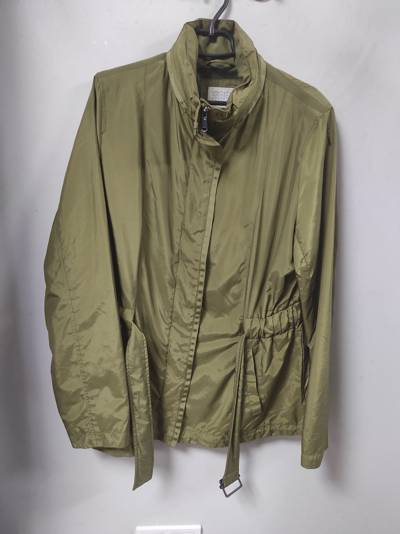

In [26]:
 image = ex["image"]
 image

In [27]:
labels = data["train"].features["label"]
labels

ClassLabel(names=['Hat', 'Longsleeve', 'Outwear', 'Pants', 'Shoes', 'Shorts', 'Shortsleeve'], id=None)

In [28]:
metric = datasets.load_metric("accuracy")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [29]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3887
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 686
    })
})

In [30]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i
  id2label[i] = label

In [31]:
from transformers import AutoImageProcessor
model_name_or_path = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)

In [32]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

size = image_processor.size
if "height" in size:
    crop_size = (size["height"], size["width"])
    resize_size = (size["height"], size["width"])
elif "shortest_edge" in size:
    crop_size = resize_size = size["shortest_edge"]

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(resize_size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [33]:
train_ds = data["train"]
val_ds = data["test"]

In [34]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [35]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x533>,
 'label': 6,
 'pixel_values': tensor([[[ 0.3176,  0.3098,  0.2941,  ...,  0.7333,  0.7490,  0.7176],
          [ 0.3255,  0.3255,  0.3098,  ...,  0.7176,  0.7255,  0.6863],
          [ 0.3255,  0.3255,  0.3176,  ...,  0.7098,  0.7020,  0.6627],
          ...,
          [ 0.8118,  0.7961,  0.8275,  ...,  0.4824,  0.6627,  0.8824],
          [ 0.8039,  0.7882,  0.8118,  ...,  0.4588,  0.6549,  0.8667],
          [ 0.8039,  0.8039,  0.8118,  ...,  0.4510,  0.6549,  0.8745]],
 
         [[-0.8824, -0.8902, -0.8902,  ..., -0.6549, -0.6392, -0.6392],
          [-0.8745, -0.8824, -0.8902,  ..., -0.6784, -0.6471, -0.6235],
          [-0.8745, -0.8824, -0.8902,  ..., -0.6627, -0.6627, -0.6392],
          ...,
          [ 0.8745,  0.8588,  0.8902,  ...,  0.4353,  0.6157,  0.8745],
          [ 0.8667,  0.8510,  0.8745,  ...,  0.4196,  0.6078,  0.8588],
          [ 0.8667,  0.8667,  0.8745,  ...,  0.4196,  0.6157,  0.8667]]

In [36]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
import accelerate
from transformers import TrainingArguments
training_args = TrainingArguments(
    'finetuned-clothes',
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=5e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)

In [38]:
import numpy as np
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [39]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [40]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [41]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1122150055GF
  train_loss               =       0.3586
  train_runtime            =   0:08:05.68
  train_samples_per_second =       32.013
  train_steps_per_second   =        4.003


In [42]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9359
  eval_loss               =     0.2339
  eval_runtime            = 0:00:06.37
  eval_samples_per_second =    107.662
  eval_steps_per_second   =     13.497
